# Research Question 2: How did the performance treatments influence the relevant metrics of the Climate Superemulator?
# RQ 2.1: What Batchsize minimizes Execution time without decreasing accuracy by more than 1% compared to the baseline?

In [1]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
pip install jinja2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import statistics


## Setup and Data Loading from Wandb

In [10]:
api = wandb.Api()

Baseline = api.runs(f"causalpaca/emulator", filters = {'group' : "Baseline", 'tags': "6_models"})
BS_Unet = api.runs(f"causalpaca/emulator", filters = {'group' : "BatchSize_Unet"})
BatchSize_convlstm = api.runs(f"causalpaca/emulator", filters = {'group' : "BatchSize_convlstm"})
BS_climax = api.runs(f"causalpaca/emulator", filters = {'group' : "BatchSize_climax"})
BS_climax_frozen = api.runs(f"causalpaca/emulator", filters = {'group' : "BatchSize_climax_frozen"})



occurrences = {}
occurrences_eval = {}

All_BS_Experiments = [Baseline,BatchSize_convlstm,BS_Unet,BS_climax,BS_climax_frozen]
for experiment in All_BS_Experiments:
    for run in experiment:
        try:
            value = run.config["datamodule"]["batch_size"]
            value_eval = run.config["datamodule"]["eval_batch_size"]
        except: 
            value = run.config["datamodule/batch_size"]
            value_eval = run.config["datamodule/eval_batch_size"]

        if value in occurrences:
            occurrences[value] += 1
        else:
            occurrences[value] = 1
        
        if value_eval in occurrences_eval:
            occurrences_eval[value] += 1
        else:
            occurrences_eval[value] = 1

Treatment_Names = [2,4,8,16,32]

print("Number of runs for each batchsize (test): ", occurrences)
print("Number of runs for each batchsize - evaluation (test): ", occurrences_eval)
counts = list(occurrences.values())
counts_eval = list(occurrences_eval.values())
# Checks if all batchsizes occur same often!
print("THIS SHOULD BE TRUE: ", all(count == counts[0] for count in counts))
print("THIS SHOULD BE TRUE: ", all(count == counts[0] for count in counts_eval))


    

Number of runs for each batchsize (test):  {2: 8, 16: 8, 32: 8, 8: 8, 4: 8}
Number of runs for each batchsize - evaluation (test):  {2: 8, 16: 8, 32: 8, 8: 8, 4: 8}
THIS SHOULD BE TRUE:  True
THIS SHOULD BE TRUE:  True


In [11]:
def extract_parts_from_name(name):
    """
    Extracts parts from a given name.
    """
    parts = name.split('_')
    new_name = parts[1]
    if(parts[2]=="frozen"):
      new_name = new_name +"_"+ parts[2]
    return new_name

def filter_system_metrics(system_metrics, filter_criteria):
    """
    Filters system metrics based on specified criteria.
    """
    filtered_columns = [metric[0] for metric in filter_criteria]

    return system_metrics[filtered_columns]


data = []
for index, ml_model in enumerate(All_BS_Experiments):
  for run in ml_model:
      # Fetching metrics for the specified run
      try:
         name = run.config["model"]["model_name"]
      except: 
         name = run.config["model/model_name"]
      time = run.summary["_wandb"].runtime/60 # in minutes
      emissions = run.summary["emissions"]
      
      try:
        bs = run.config["datamodule"]["batch_size"]
      except:
        bs = run.config["datamodule/batch_size"]

      # Retrieving system metrics history
      default_metrics = run.history(stream="default",pandas=True)
      train_time = default_metrics["time/train"].dropna().to_numpy()
      epoch = default_metrics["epoch"].dropna().to_numpy()
      accuracy = default_metrics["val/rmse"].dropna().to_numpy()
      
      system_metrics = run.history(stream="system",pandas=True)

      # print("defaul metrics\n")
      # print(model.scan_history())
      filter_criteria = [
          ['system.cpu'],
          ['system.gpu.process.0.gpu'],
          ['system.proc.memory.rssMB'],
      ]
      # Filtering system metrics based on the specified criteria
      system_metrics_filtered = filter_system_metrics(system_metrics, filter_criteria)

      # Create a new DataFrame for the current row
      data.append({
        "name": name,
        "Treatment": bs,
        "Time/Train": train_time,
        "CPU": system_metrics_filtered['system.cpu'].dropna().to_list(),
        "GPU": system_metrics_filtered['system.gpu.process.0.gpu'].dropna().to_list(),
        "RSS-Memory in GB": system_metrics_filtered['system.proc.memory.rssMB'].dropna().to_list(),
        "RMSE": accuracy,
        "Epochs": epoch,
        "runtime_hours": time,
        "Co2": emissions,
      })
      print(name, statistics.mean(train_time))


print(len(data))
# Convert the list of dictionaries to a DataFrame


unet 46.6571852585365
convlstm 16.549322809491837
climax_frozen 102.72853107941457
climax 142.32861672678303
climax 141.78379397922092
unet 47.42759138962318
convlstm 9.733727737709328
climax_frozen 99.46922781808036
convlstm 5.958782196044922
convlstm 5.695172758102417
convlstm 6.025887230168218
convlstm 7.338541195942805
convlstm 5.588475956916809
convlstm 5.4812512826919555
convlstm 6.321563541889191
convlstm 7.438052705356053
unet 37.84462013244629
unet 36.600587348937985
unet 39.200419261537746
unet 36.51360157557896
unet 35.73605247497559
unet 35.33238590240479
unet 36.803544094688014
unet 41.64294530990276
climax 113.20228866577149
climax 113.76705101013184
climax 118.47173826721892
climax 126.00316144599289
climax 117.80662562338154
climax 112.10499473571777
climax 113.96372787475586
climax 128.12472098214286
climax_frozen 90.60632972717285
climax_frozen 90.49442169189453
climax_frozen 94.34452073470406
climax_frozen 112.49621481973617
climax_frozen 89.9910181427002
climax_froz

In [12]:
runs_count = {}
for d in data:
    key = (d["name"], d["Treatment"])
    runs_count[key] = runs_count.get(key, 0) + 1
print(runs_count)

{('unet', 2): 2, ('convlstm', 2): 2, ('climax_frozen', 2): 2, ('climax', 2): 2, ('convlstm', 16): 2, ('convlstm', 32): 2, ('convlstm', 8): 2, ('convlstm', 4): 2, ('unet', 32): 2, ('unet', 16): 2, ('unet', 4): 2, ('unet', 8): 2, ('climax', 32): 2, ('climax', 16): 2, ('climax', 8): 2, ('climax', 4): 2, ('climax_frozen', 16): 2, ('climax_frozen', 32): 2, ('climax_frozen', 8): 2, ('climax_frozen', 4): 2}


In [26]:
# Merge the Multiples
mean_data = {}


for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    CPU_Lists=[]
    GPU_Lists=[]
    RSS_Lists=[]
    RMSE_Lists=[]
    Steps_Lists=[]
    Runtime_Lists=[]
    CO2_Lists=[]
    Time_train_list = []
    for d in data: 
        if d["name"] == run[0] and d["Treatment"] == run[1]:
            CPU_Lists.append(d["CPU"])
            GPU_Lists.append(d["GPU"])
            RSS_Lists.append(d["RSS-Memory in GB"])
            RMSE_Lists.append(d["RMSE"])
            Steps_Lists.append(d["Epochs"])
            Runtime_Lists.append(d["runtime_hours"])
            CO2_Lists.append(d["Co2"])
            Time_train_list.append(d["Time/Train"])


    if (number_runs>=2):
        mean_data[(run[0], run[1])] = {
            "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
            "time/train": [(x + y)/2 for x, y in zip(Time_train_list[0], Time_train_list[1])],
            "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
            "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
            "RMSE": [(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])],
            "Epochs": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
            "runtime_hours": statistics.mean(Runtime_Lists),
            "Co2": statistics.mean(CO2_Lists)*100
        }
        print(run[0], run[1],statistics.mean(CO2_Lists)*100)
    else:
        print("skipped")

print(mean_data)

unet 2 0.10303751683469935
convlstm 2 0.02182168357592646
climax_frozen 2 0.1804708236071748
climax 2 0.2571333940229249
convlstm 16 0.01100081635017168
convlstm 32 0.012043542288515648
convlstm 8 0.011363423213163994
convlstm 4 0.012880441945720694
unet 32 0.07794665477719079
unet 16 0.07856700707437828
unet 4 0.09628026463855319
unet 8 0.0871908057904701
climax 32 0.1982016690332329
climax 16 0.20184598189460162
climax 8 0.20568861747651052
climax 4 0.22262359042869145
climax_frozen 16 0.15088600438416772
climax_frozen 32 0.1524628461185874
climax_frozen 8 0.15987724078973062
climax_frozen 4 0.1540693366125183
{('unet', 2): {'CPU': [1.5150000000000001, 2.935, 3.0149999999999997, 3.05, 2.88, 2.98, 2.9450000000000003, 2.9400000000000004, 3.0, 2.9050000000000002, 2.9850000000000003, 2.975, 2.8899999999999997, 2.975, 2.94, 2.955, 3.025, 2.98, 2.99, 3.0149999999999997, 2.87, 2.995, 2.98, 2.9450000000000003, 2.995, 2.965, 2.96, 3.005, 2.935, 3.015, 2.9450000000000003, 2.95, 2.975, 2.945000

## Overview of Mean, Median and STD

In [21]:
import math

# data_scheme={
#     "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
#     "time/train": [(x + y)/2 for x, y in zip(Time_train_list[0], Time_train_list[1])],
#     "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
#     "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
#     "RMSE": [(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])],
#     "Epochs": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
#     "runtime_minutes": statistics.mean(Runtime_Lists),
#     "Co2": statistics.mean(CO2_Lists)
# }




rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    if(number_runs>=2):
        name = run[0]
        ml_model = run[1]
        data_for_run = mean_data.get((run[0], run[1]),0)
        unique_epochs = np.unique([math.floor(float(x)) for x in data_for_run["Epochs"]])
        new_row = {
            "Name":name, 
            "Treatment":ml_model,
            "Min_RMSE": min(data_for_run["RMSE"]),
            "RMSE_Mean": statistics.mean(data_for_run["RMSE"]), 
            "RMSE_Median": statistics.median(data_for_run["RMSE"]), 
            "RMSE_STD": statistics.stdev(data_for_run["RMSE"]), 
            "Time/Train Mean_Minutes": statistics.mean(data_for_run["time/train"])/60,
            "Time/Train Median_Minutes": statistics.median(data_for_run["time/train"])/60,
            "Time/Train STD_Minutes": statistics.stdev(data_for_run["time/train"])/60,
            "CPU_Mean": statistics.mean(data_for_run["CPU"]), 
            "CPU_Median": statistics.median(data_for_run["CPU"]), 
            "CPU_STD": statistics.stdev(data_for_run["CPU"]), 
            "GPU_Mean": statistics.mean(data_for_run["GPU"]), 
            "GPU_Median": statistics.median(data_for_run["GPU"]), 
            "GPU_STD": statistics.stdev(data_for_run["GPU"]), 
            "RSS-Memory_Mean": statistics.mean(data_for_run["RSS-Memory in GB"]), 
            "RSS-Memory_Median": statistics.median(data_for_run["RSS-Memory in GB"]), 
            "RSS-Memory_STD": statistics.stdev(data_for_run["RSS-Memory in GB"]), 
            "Runtime_Minutes":  data_for_run["runtime_hours"],
            "Co2": data_for_run["Co2"],
            }
        
        rows.append(new_row)


new_df = pd.DataFrame(rows)
finalized_data = new_df.sort_values(by='Treatment')
finalized_data = new_df.sort_values(by=['Name','Treatment'])
def round_if_float(x):
    if isinstance(x, float):
        rounded_value = round(x, 3)
        return rounded_value
    return x
finalized_data = finalized_data.applymap(round_if_float)
finalized_data = finalized_data.applymap(round_if_float)
selected_columns = ['Name', 'Treatment', 'RMSE_Mean',"Min_RMSE", "Time/Train Mean_Minutes","Time/Train Median_Minutes","Time/Train STD_Minutes","Runtime_Minutes"]
selected_column = ['Name', 'Treatment',"Time/Train Mean_Minutes", "Co2"]

new_df = finalized_data[selected_columns].copy()
latex_table = finalized_data.to_latex(index=False,float_format="%.3f")
smaller_table = new_df.to_latex(index=False,float_format="%.3f")

print(finalized_data[selected_column])

#print(smaller_table)



ValueError: cannot convert NaN to integer ratio

In [15]:
filtered_df = finalized_data[((finalized_data['Name'] == 'climax') & (finalized_data['Treatment'] == 16)) |
                 ((finalized_data['Name'] == 'climax') & (finalized_data['Treatment'] == 2)) |
                 ((finalized_data['Name'] == 'climax_frozen') & (finalized_data['Treatment'] == 8)) |
                 ((finalized_data['Name'] == 'climax_frozen') & (finalized_data['Treatment'] == 2)) |
                 ((finalized_data['Name'] == 'convlstm') & (finalized_data['Treatment'] == 4)) |
                 ((finalized_data['Name'] == 'convlstm') & (finalized_data['Treatment'] == 2)) |
                 ((finalized_data['Name'] == 'unet') & (finalized_data['Treatment'] == 32)) |
                 ((finalized_data['Name'] == 'unet') & (finalized_data['Treatment'] == 2))]
selected_columns_df = filtered_df[['Time/Train Mean_Minutes', 'Name', 'Treatment', 'Min_RMSE']].reset_index(drop=True)


print(selected_columns_df)

   Time/Train Mean_Minutes           Name  Treatment  Min_RMSE
0                    2.374         climax          2     1.165
1                    1.898         climax         16     0.831
2                    1.687  climax_frozen          2     0.632
3                    1.578  climax_frozen          8     0.635
4                    0.219       convlstm          2     0.555
5                    0.123       convlstm          4     0.554
6                    0.784           unet          2     1.225
7                    0.613           unet         32     0.528


   Time/Train Mean_Minutes           Name  Treatment  Min_RMSE
0                    2.374         climax          2     1.165
1                    1.898         climax         16     0.831
2                    1.687  climax_frozen          2     0.632
3                    1.578  climax_frozen          8     0.635
4                    0.219       convlstm          2     0.555
5                    0.123       convlstm          4     0.554
6                    0.784           unet          2     1.225
7                    0.613           unet         32     0.528


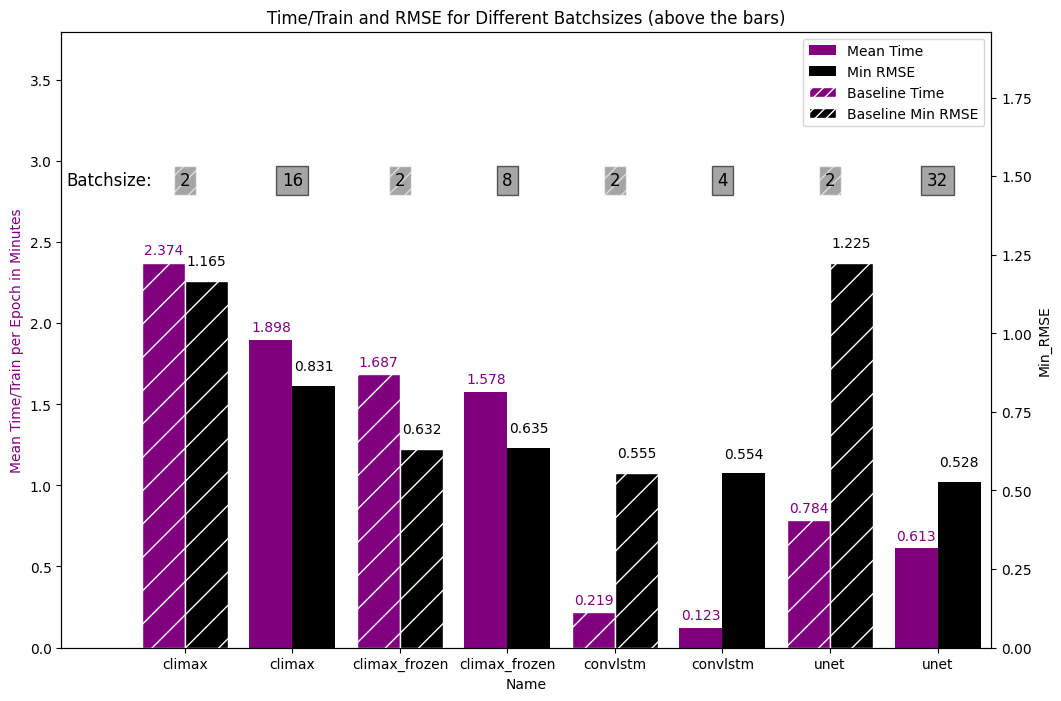

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

keyword_rmse = "Min_RMSE"
# Assuming df is your dataframe
df = selected_columns_df
print(df)
# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))
max_time_train = df['Time/Train Mean_Minutes'].max()
max_min_rmse = df['Min_RMSE'].max()
# Plot the Time/Train Mean_Minutes with dashed bars for Treatment == 2
ax1.set_xlabel('Name')
ax1.set_ylabel('Mean Time/Train per Epoch in Minutes', color='purple')
bars1 = ax1.bar(df.index - 0.2, df['Time/Train Mean_Minutes'], width=0.4, label='Mean Time/Train per Epoch in Minutes', color='purple')
for i, bar in enumerate(bars1):
    if df['Treatment'][i] == 2:
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Create a second y-axis for RMSE
ax2 = ax1.twinx()
ax2.set_ylabel(keyword_rmse, color='black')
bars2 = ax2.bar(df.index + 0.2, df[keyword_rmse], width=0.4, label=keyword_rmse, color='black')
for i, bar in enumerate(bars2):
    if df['Treatment'][i] == 2:
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Adding names as x-axis labels
ax1.set_xticks(df.index)
ax1.set_xticklabels(df['Name'])

# Annotate the bars with Treatment values
for i in range(len(df)):
    ax1.text(df.index[i] - 0.2, df['Time/Train Mean_Minutes'][i] + 0.05, str(df['Time/Train Mean_Minutes'][i]), ha='center', color='purple')
    ax2.text(df.index[i] + 0.2, df[keyword_rmse][i] + 0.05, str(df[keyword_rmse][i]), ha='center', color='black')
    if df['Treatment'][i] == 2:
        if(i==0):
            ax2.text(df.index[i]- 0.7, max_min_rmse * 1.2, "Batchsize:", ha='center', color='black',fontsize=12)
        ax2.text(df.index[i], max_min_rmse * 1.2, df["Treatment"][i], ha='center', color='black',fontsize=12, bbox=dict(facecolor='dimgray', alpha=0.6, hatch="//",edgecolor="white"))
    else:
        ax2.text(df.index[i], max_min_rmse * 1.2, df["Treatment"][i], ha='center', color='black',fontsize=12, bbox=dict(facecolor='dimgray', alpha=0.6))


# Add legend with grouped labels
purple_patch = plt.Rectangle((0, 0), 1, 1, fc="purple", hatch="")
black_patch = plt.Rectangle((0, 0), 1, 1, fc="black", hatch="")
dashed_purple_patch = plt.Rectangle((0, 0), 1, 1, fc="purple",edgecolor="white", hatch="///")
dashed_black_patch = plt.Rectangle((0, 0), 1, 1, fc="black",edgecolor="white", hatch="///")

# dashed_purple_patch = plt.Line2D([], [], color="purple", marker='', linestyle='None', markersize=10, markerfacecolor='white', label='Baseline Time')
# dashed_black_patch = plt.Line2D([], [], color="black", marker='', linestyle='None', markersize=10, markerfacecolor='white', label='Baseline RMSE')
plt.legend(handles=[purple_patch, black_patch, dashed_purple_patch, dashed_black_patch],
           labels=['Mean Time', 'Min RMSE', 'Baseline Time', 'Baseline Min RMSE'], loc='upper right')

plt.title('Time/Train and RMSE for Different Batchsizes (above the bars)')

ax1.set_ylim(0, max_time_train * 1.6)
ax2.set_ylim(0, max_min_rmse * 1.6)
ax1.set_xlim(df.index[0] - 1.15, df.index[-1] + 0.5)

# Save the figure
fig.savefig("figures/RQ_2.1_combined_bar/RQ_2.1_combined_bar.png")

# Show plot
plt.show()


In [17]:
finalized_data

filtered_df = finalized_data[((finalized_data['Name'] == 'climax') & (finalized_data['Treatment'] == 16)) |
                 ((finalized_data['Name'] == 'climax') & (finalized_data['Treatment'] == 2)) |
                 ((finalized_data['Name'] == 'climax_frozen') & (finalized_data['Treatment'] == 8)) |
                 ((finalized_data['Name'] == 'climax_frozen') & (finalized_data['Treatment'] == 2)) |
                 ((finalized_data['Name'] == 'convlstm') & (finalized_data['Treatment'] == 4)) |
                 ((finalized_data['Name'] == 'convlstm') & (finalized_data['Treatment'] == 2)) |
                 ((finalized_data['Name'] == 'unet') & (finalized_data['Treatment'] == 32)) |
                 ((finalized_data['Name'] == 'unet') & (finalized_data['Treatment'] == 2))]
selected_columns_df = filtered_df[['Time/Train Mean_Minutes', 'Name', 'Treatment', 'RMSE_Mean']].reset_index(drop=True)


print(selected_columns_df)

   Time/Train Mean_Minutes           Name  Treatment  RMSE_Mean
0                    2.374         climax          2      1.618
1                    1.898         climax         16      1.100
2                    1.687  climax_frozen          2      0.816
3                    1.578  climax_frozen          8      0.748
4                    0.219       convlstm          2      0.603
5                    0.123       convlstm          4      0.634
6                    0.784           unet          2      1.375
7                    0.613           unet         32      0.657


In [18]:
def extract_parts_from_name(name):
    """
    Extracts parts from a given name.
    """
    parts = name.split('_')
    new_name = parts[1]
    if(parts[2]=="frozen"):
      new_name = new_name +"_"+ parts[2]
    return new_name

def filter_system_metrics(system_metrics, filter_criteria):
    """
    Filters system metrics based on specified criteria.
    """
    filtered_columns = [metric[0] for metric in filter_criteria]

    return system_metrics[filtered_columns]


data = []
for index, ml_model in enumerate(All_BS_Experiments):
  for run in ml_model:
      # Fetching metrics for the specified run
      try:
         name = run.config["model"]["model_name"]
      except: 
         name = run.config["model/model_name"]
      time = run.summary["_wandb"].runtime/60 # in minutes
      emissions = run.summary["emissions"]
      
      try:
        bs = run.config["datamodule"]["batch_size"]
      except:
        bs = run.config["datamodule/batch_size"]

      # Retrieving system metrics history
      default_metrics = run.history(stream="default",pandas=True)
      train_time = default_metrics["time/train"].ffill().to_numpy()
      epoch = default_metrics["epoch"].ffill().to_numpy()
      accuracy = default_metrics["val/rmse"].ffill().to_numpy()
      
      system_metrics = run.history(stream="system",pandas=True)

      # print("defaul metrics\n")
      # print(model.scan_history())
      filter_criteria = [
          ['system.cpu'],
          ['system.gpu.process.0.gpu'],
          ['system.proc.memory.rssMB'],
      ]
      # Filtering system metrics based on the specified criteria
      system_metrics_filtered = filter_system_metrics(system_metrics, filter_criteria)

      # Create a new DataFrame for the current row
      data.append({
        "name": name,
        "Treatment": bs,
        "Time/Train": train_time,
        "CPU": system_metrics_filtered['system.cpu'].dropna().to_list(),
        "GPU": system_metrics_filtered['system.gpu.process.0.gpu'].dropna().to_list(),
        "RSS-Memory in GB": system_metrics_filtered['system.proc.memory.rssMB'].dropna().to_list(),
        "RMSE": accuracy,
        "Epochs": epoch,
        "runtime_hours": time,
        "Co2": emissions,
      })
      print(name)
      print(len(accuracy))

print(len(data))
# Convert the list of dictionaries to a DataFrame

# Merge the Multiples
mean_data = {}


for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    print(number_runs)
    print()
    print(run[0],run[1])
    CPU_Lists=[]
    GPU_Lists=[]
    RSS_Lists=[]
    RMSE_Lists=[]
    Steps_Lists=[]
    Runtime_Lists=[]
    CO2_Lists=[]
    Time_train_list = []
    for d in data: 
        if d["name"] == run[0] and d["Treatment"] == run[1]:
            CPU_Lists.append(d["CPU"])
            GPU_Lists.append(d["GPU"])
            RSS_Lists.append(d["RSS-Memory in GB"])
            RMSE_Lists.append(d["RMSE"])
            Steps_Lists.append(d["Epochs"])
            Runtime_Lists.append(d["runtime_hours"])
            CO2_Lists.append(d["Co2"])
            Time_train_list.append(d["Time/Train"])

    print(len([(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])]))


    if (number_runs>=2):
        mean_data[(run[0], run[1])] = {
            "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
            "time/train": [(x + y)/2 for x, y in zip(Time_train_list[0], Time_train_list[1])],
            "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
            "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
            "RMSE": [(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])],
            "Epochs": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
            "runtime_hours": statistics.mean(Runtime_Lists),
            "Co2": statistics.mean(CO2_Lists)
        }
    else:
        print("skipped")

print(mean_data)


unet
500
convlstm
500
climax_frozen
500
climax
500
climax
500
unet
500
convlstm
500
climax_frozen
500
convlstm
378
convlstm
290
convlstm
500
convlstm
500
convlstm
290
convlstm
378
convlstm
500
convlstm
500
unet
290
unet
378
unet
500
unet
500
unet
290
unet
378
unet
500
unet
500
climax
290
climax
378
climax
500
climax
500
climax
500
climax
290
climax
378
climax
500
climax_frozen
378
climax_frozen
290
climax_frozen
500
climax_frozen
500
climax_frozen
290
climax_frozen
378
climax_frozen
500
climax_frozen
500
40
2

unet 2
500
2

convlstm 2
500
2

climax_frozen 2
500
2

climax 2
500
2

convlstm 16
378
2

convlstm 32
290
2

convlstm 8
500
2

convlstm 4
500
2

unet 32
290
2

unet 16
378
2

unet 4
500
2

unet 8
500
2

climax 32
290
2

climax 16
378
2

climax 8
500
2

climax 4
500
2

climax_frozen 16
378
2

climax_frozen 32
290
2

climax_frozen 8
500
2

climax_frozen 4
500
{('unet', 2): {'CPU': [1.5150000000000001, 2.935, 3.0149999999999997, 3.05, 2.88, 2.98, 2.9450000000000003, 2.94000000000000

In [19]:
# import seaborn as sns
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# from seaborn_qqplot import pplot
# from scipy.stats import gamma
# from PIL import Image
# import statsmodels.api as sm 
# import pylab as py 



# already_used_name=[]
# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if(number_runs >= 2 and (run[0] not in already_used_name)):
#         already_used_name.append(run[0])
#         name = run[0]
#         all_RMSE = []
#         for i in range(len(Treatment_Names)):
#             new_data = mean_data.get((run[0], Treatment_Names[i]), 0)
#             print(len(new_data["RMSE"]))
#             all_RMSE.append(new_data["RMSE"])
#         df = pd.DataFrame(new_data).T 
#         # Plot using Seaborn
#         sns.set(style="whitegrid")  # Set the style
#         plt.figure(figsize=(10, 6))  # Set the figure size

#         # Plot each line
#         for i, line in enumerate(data):
#             plt.plot(line, label=f'Line {i+1}')

#         plt.xlabel('X-axis Label')
#         plt.ylabel('Y-axis Label')
#         plt.title('Multi-Line Plot')
#         plt.legend()
#         plt.show()
#         # epochs = {"Epochs": np.arange(100)}
#         # results_df = pd.DataFrame(epochs)
#         # for i in range(len(Treatment_Names)):
#         #     data = mean_data.get((run[0], Treatment_Names[i]), 0)
#         #     # Create a dictionary with the values for the new row
#         #     RMSE = np.array(data["RMSE"])
#         #     Time_Train = np.array(data["time/train"])
            
#         #     data = {f'{Treatment_Names[i]}_RMSE': RMSE, '{Treatment_Names[i]}_Time/Train':Time_Train}
#         #     json_df = pd.DataFrame(data)
#         #     print(json_df)
#         #     results_df = pd.concat([results_df, json_df], ignore_index=True)
#         #     # Append the new row to the DataFrame
        
#         # print(results_df)
#         # fig, axes = plt.subplots(1, 2, figsize=(18, 12)) 

#         # BS_Lineplots(axes[0], results_df, f"RMSE - {run[0]}", "RMSE")
#         # BS_Lineplots(axes[0], results_df, f"Time/Train - {run[0]}", "Time/Minutes")
#         # plt.tight_layout()
#         # plt.show()
        

#         #  # Create a 2x3 grid of subplots

        
#         # BS_Lineplots(axes[1], data_for_run_0["CPU"],data_for_run_1["CPU"], f"CPU - {run[0]}", "Percent")
        
        



